In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import r2_score

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Data Cleaning

- For nulls in nominal categories, we can fill them with "NA" or 0 depending on what the category means based off of the dataset's documentation.

In [3]:
#Imputing the values for Lot Frontage, since it was the only column we can't just fill with 0 or "NA"

combined_df = pd.concat([train_df, test_df], axis = 0)
combined_df.isnull().shape
combined_df['Lot Frontage'].isnull().sum()

IR1_median = combined_df.loc[combined_df['Lot Shape'] == "IR1",'Lot Frontage'].median()
IR2_median = combined_df.loc[combined_df['Lot Shape'] == "IR2",'Lot Frontage'].median()
IR3_median = combined_df.loc[combined_df['Lot Shape'] == "IR3",'Lot Frontage'].median()
Reg_median = combined_df.loc[combined_df['Lot Shape'] == "Reg",'Lot Frontage'].median()

#Calculated from the concatenated df's.  I felt the median was more represntative based on SalePrice.

In [4]:
def DataCleaner(df):
    
    df['Lot Frontage'].fillna(0, inplace = True)
    
    new_list = []
    df['Lot Frontage'].fillna(0, inplace = True)
    for row in range(0,df.shape[0]):

        if df.loc[row,'Lot Frontage'] != 0:
            new_list.append(df.loc[row,'Lot Frontage'])

        elif df.loc[row,'Lot Frontage'] == 0:

            if df.loc[row,:].loc['Lot Shape'] == "IR1":
                new_list.append(IR1_median)

            if df.loc[row,:].loc['Lot Shape'] == "IR2":
                 new_list.append(IR2_median)

            if df.loc[row,:].loc['Lot Shape'] == "IR3":
                 new_list.append(IR3_median)

            if df.loc[row,:].loc['Lot Shape'] == "Reg":
                 new_list.append(Reg_median)

    df['Lot Frontage'] = new_list
    
    df['Pool QC'].fillna('NA', inplace = True)
    df['Misc Feature'].fillna('NA', inplace = True)
    df['Alley'].fillna("NA", inplace = True)
    df['Fence'].fillna("NA", inplace = True)
    df['Fireplace Qu'].fillna("NA", inplace = True)
    df['Garage Finish'].fillna("NA", inplace = True)
    df['Garage Qual'].fillna("NA", inplace = True)
    df['Garage Yr Blt'] = train_df['Year Built']
    df['Garage Cond'].fillna("NA", inplace = True)
    df['Garage Type'].fillna("NA", inplace = True)
    df['Bsmt Exposure'].fillna("NA", inplace = True)
    df['BsmtFin Type 2'].fillna("NA", inplace = True)
    df['BsmtFin Type 1'].fillna("NA", inplace = True)
    df['Bsmt Qual'].fillna("NA", inplace = True)
    df['Bsmt Cond'].fillna("NA", inplace = True)
    df['Mas Vnr Area'].fillna(0.0, inplace = True)
    df['Mas Vnr Type'].fillna("None", inplace = True)
    df['Bsmt Half Bath'].fillna(0.0, inplace = True)
    df['Bsmt Full Bath'].fillna(0.0, inplace = True)
    df['Bsmt Unf SF'].fillna(0.0, inplace = True)
    df['BsmtFin SF 1'].fillna(0.0, inplace = True)
    df['Total Bsmt SF'].fillna(0.0, inplace = True)
    df['BsmtFin SF 2'].fillna(0.0, inplace = True)  
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['Garage Area'].fillna(0.0, inplace = True)
    df['Garage Cars'].fillna(0.0, inplace = True)
    df['MS SubClass'] = df['MS SubClass'].astype('str')

    # Assigning values to ordinal categories

    lot_shape_maps = {
        "Reg" : 0,
        "IR1" : 1,
        "IR2" : 2,
        "IR3" : 3
    }

    df['Lot Shape'] = df['Lot Shape'].map(lot_shape_maps);

    land_slope_maps = {
        "Gtl":0,
        "Mod":1,
        "Sev":2
    }

    df['Land Slope'] = df['Land Slope'].map(land_slope_maps)

    bsmt_qual_maps = {
        "NA":0,
        "Po":1,
        "Fa":2,
        "TA":3,
        "Gd":4,
        "Ex":5
    }

    df['Bsmt Qual'] = df['Bsmt Qual'].map(bsmt_qual_maps)

    bsmt_cond_maps = {
        "NA":0,
        "Po":1,
        "Fa":2,
        "TA":3,
        "Gd":4,
        "Ex":5
    }

    df['Bsmt Cond'] = df['Bsmt Cond'].map(bsmt_cond_maps)

    bsmt_fin_maps = {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0
    }

    bsmt_exp_maps = {
        "Gd": 4,
        "Av": 3,
        "Mn": 2,
        "No": 1,
        "NA": 0
    }

    df['Bsmt Exposure'] = df['Bsmt Exposure'].map(bsmt_exp_maps)

    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(bsmt_fin_maps)
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(bsmt_fin_maps)

    exter_maps = {
        "Ex":4,
        "Gd":3,
        "TA":2,
        "Fa":1,
        "Po":0
    }

    df['Exter Qual'] = df['Exter Qual'].map(exter_maps)
    df['Exter Cond'] = df['Exter Cond'].map(exter_maps)

    heating_maps = {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0
    }

    df['Heating QC'] = df['Heating QC'].map(heating_maps)

    kitchen_maps = {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0
    }

    df['Kitchen Qual'] = df['Kitchen Qual'].map(kitchen_maps)

    function_maps ={
           "Typ": 7,
           "Min1": 6,
           "Min2": 5,
           "Mod": 4,
           "Maj1": 3,
           "Maj2": 2,
           "Sev": 1,
           "Sal": 0
    }

    df['Functional'] = df['Functional'].map(function_maps)

    fireplace_maps = {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0

    }

    df['Fireplace Qu'] = df['Fireplace Qu'].map(fireplace_maps)

    garage_finish_maps = {
        "Fin":3,
        "RFn":2,
        "Unf":1,
        "NA":0,
    }

    df['Garage Finish'] = df['Garage Finish'].map(garage_finish_maps)

    garage_qual_cond_maps = {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0

    }

    df['Garage Qual'] = df['Garage Qual'].map(garage_qual_cond_maps)
    df['Garage Cond'] = df['Garage Cond'].map(garage_qual_cond_maps)

    pave_maps = {
        "Y":2,
        "P":1,
        "N":0
    }

    df['Paved Drive'] = df['Paved Drive'].map(pave_maps)

    poolqc_maps={
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "NA": 0
    }

    df['Pool QC'] = df['Pool QC'].map(poolqc_maps)

    util_maps = {
        "AllPub": 2,
        "NoSewr": 1,
        "NoSeWa": 0,
    }

    df['Utilities'] = df['Utilities'].map(util_maps)

    fence_maps = {
           "GdPrv":4,
           "MnPrv":3,
           "GdWo":2,
           "MnWw":1,
           "NA":0
    }

    df['Fence'] = df['Fence'].map(fence_maps)

    electrical_maps = {
        "SBrkr": 4,
        "FuseA": 3,
        "FuseF":2,
        "FuseP":1,
        "Mix":0
    }

    df['Electrical'] = df['Electrical'].map(electrical_maps)

In [5]:
DataCleaner(train_df)
DataCleaner(test_df)

In [6]:
# Need to cut out Sale Condition in train set, since it's not in the test.
train_df.drop('Sale Condition', axis = 1, inplace = True)

- First we're going to consider the basic numerical values first.  For now, we'll prep an alternate
    dataframe that has ordinal categories mapped as well as the nominal categories converted to dummies.
    We're going to pick predictors first via EDA, then later utilize Ridge and Lasso algorithms to perform
    feature selection on all of the features together.

In [7]:
def Master_df():
    nominal_list = ['MS SubClass','Exterior 1st','Exterior 2nd',
                                 'MS Zoning', 'Street', 'Alley', 'Lot Config',
                                 'Land Contour', 'Neighborhood', 'Condition 1',
                                 'Condition 2', 'Bldg Type', 'House Style',
                                 'Roof Style', 'Roof Matl','Exterior 1st',
                                 'Exterior 2nd','Mas Vnr Type','Foundation',
                                 'Heating', 'Central Air', 'Garage Type',
                                 'Misc Feature', 'Sale Type'
                                ]

    train_nominal1_df = train_df[nominal_list[1:13]]
    train_nominal2_df = train_df[nominal_list[13:]]
    concat_nom_df = pd.concat([
        pd.get_dummies(train_nominal1_df),
        pd.get_dummies(train_nominal2_df),
        pd.get_dummies(train_df['MS Zoning'])],axis = 1)

    print(concat_nom_df.shape)

    numeric_list = []
    for item in train_df.columns:
        if item not in nominal_list:
            numeric_list.append(item)

    df_1 = train_df.loc[:,numeric_list];
    print(df_1.shape)

    master_train_df = pd.concat([df_1,concat_nom_df], axis = 1)
    print(master_train_df.shape)
    
    return master_train_df

In [8]:
Master_df()

(2051, 197)
(2051, 59)
(2051, 256)


,Id,PID,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Sale Type_New,Sale Type_Oth,Sale Type_WD,A (agr),C (all),FV,I (all),RH,RL,RM
0,109,533352170,74.0,13517,1,2,0,6,8,1976,...,0,0,1,0,0,0,0,0,1,0
1,544,531379050,43.0,11492,1,2,0,7,5,1996,...,0,0,1,0,0,0,0,0,1,0
2,153,535304180,68.0,7922,0,2,0,5,7,1953,...,0,0,1,0,0,0,0,0,1,0
3,318,916386060,73.0,9802,0,2,0,5,5,2006,...,0,0,1,0,0,0,0,0,1,0
4,255,906425045,82.0,14235,1,2,0,6,8,1900,...,0,0,1,0,0,0,0,0,1,0
5,138,535126040,137.0,16492,1,2,0,6,6,1966,...,0,0,1,0,0,0,0,0,1,0
6,2827,908186070,35.0,3675,0,2,0,6,5,2005,...,1,0,0,0,0,0,0,0,0,1
7,145,535154050,74.0,12160,1,2,0,5,5,1959,...,0,0,0,0,0,0,0,0,1,0
8,1942,535353130,65.0,15783,0,2,0,5,5,1952,...,0,0,1,0,0,0,0,0,1,0
9,1956,535426130,70.0,11606,1,2,2,5,5,1969,...,0,0,1,0,0,0,0,0,1,0


In [9]:
master_train_df = Master_df()

(2051, 197)
(2051, 59)
(2051, 256)


- From Challenge Dirty Model Copy 4, I found outliers and tried to cut them out based on these features:


- Remember, I had to do the initial cleaning first, do some EDA, then convert dummy columns for modeling.
    - There were so many features, I just chose to model based off numerical values first,
    then go back and try to figure out how the nominal categories affected the models.
    
- Note that the EDA was done just using the cleaned train_df.

- From Challenge Dirty Model Copy 4, I found outliers and tried to cut them out based on these features:

## EDA

In [10]:
# Now that the numeric values are clean, let's see how correlated they are to SalePrice.  These top ones will
# be what my preliminary EDA is.
train_df.corr()['SalePrice'].abs().sort_values(ascending = False)[0:20]

SalePrice         1.000000
Overall Qual      0.800207
Exter Qual        0.712146
Gr Liv Area       0.697038
Kitchen Qual      0.692336
Garage Area       0.649897
Garage Cars       0.647781
Total Bsmt SF     0.629303
1st Flr SF        0.618486
Bsmt Qual         0.612188
Year Built        0.571849
Garage Yr Blt     0.571849
Garage Finish     0.557839
Year Remod/Add    0.550370
Fireplace Qu      0.538925
Full Bath         0.537969
TotRms AbvGrd     0.504014
Mas Vnr Area      0.503579
Fireplaces        0.471093
Heating QC        0.458354
Name: SalePrice, dtype: float64

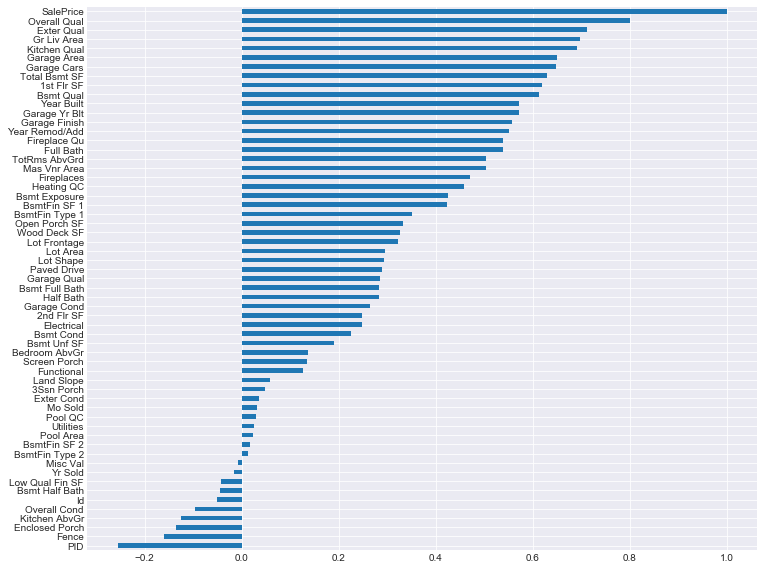

In [11]:
plt.figure(figsize = (12,10))
train_df._get_numeric_data().corr()['SalePrice'].sort_values().plot(kind = 'barh')

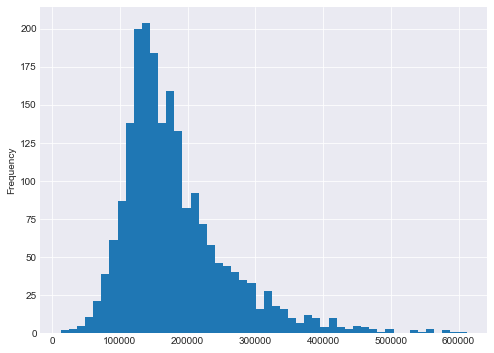

In [12]:
plt.figure(figsize = (8,6))
train_df['SalePrice'].plot(kind='hist', bins = 50)

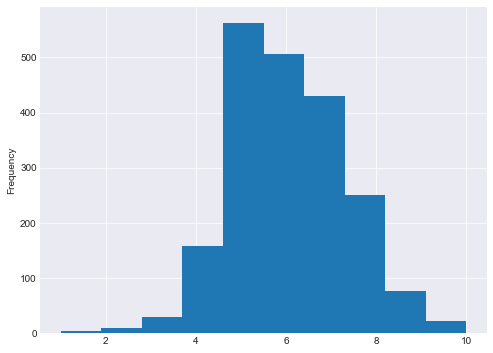

In [13]:
plt.figure(figsize = (8,6))
train_df['Overall Qual'].plot(kind='hist', bins = 10)

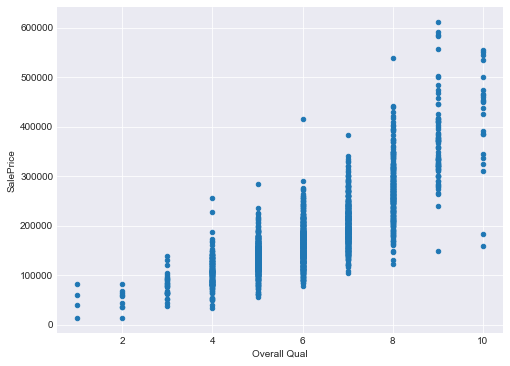

In [14]:
train_df.plot(y = 'SalePrice', x = 'Overall Qual', kind='scatter', figsize = (8,6))

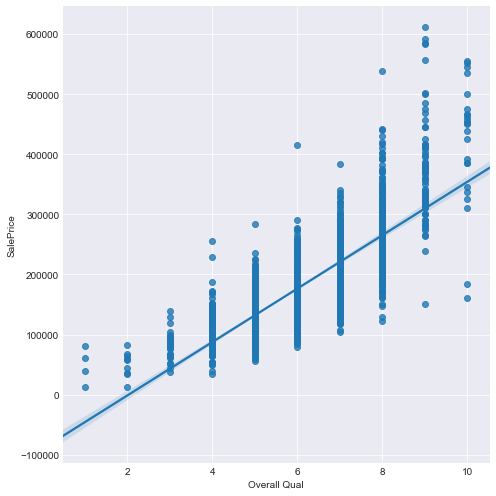

In [15]:
sns.lmplot('Overall Qual', 'SalePrice', train_df, size = 7)

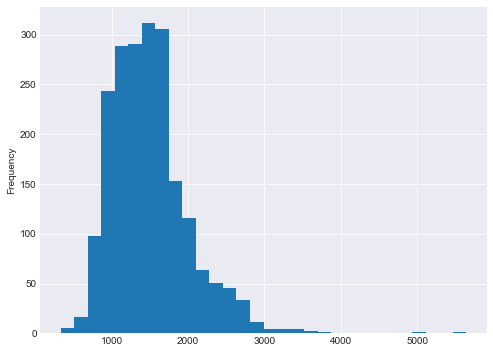

In [16]:
plt.figure(figsize = (8,6))
train_df['Gr Liv Area'].plot(kind = 'hist', bins = 30)

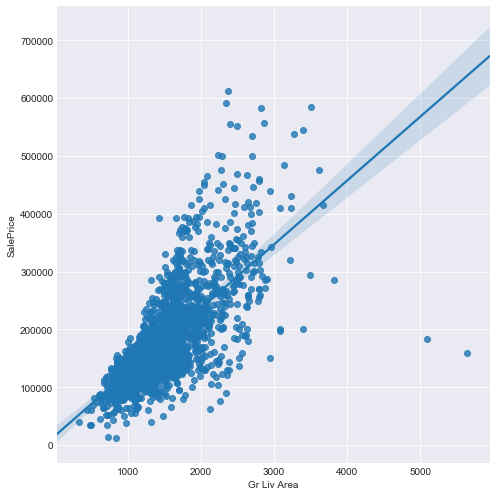

In [17]:
sns.lmplot('Gr Liv Area', 'SalePrice', train_df, size = 7)

In [18]:
predictors = train_df._get_numeric_data().corr()['SalePrice'].sort_values(ascending = False).keys()[1:9]
predictors

Index(['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual',
       'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF'],
      dtype='object')

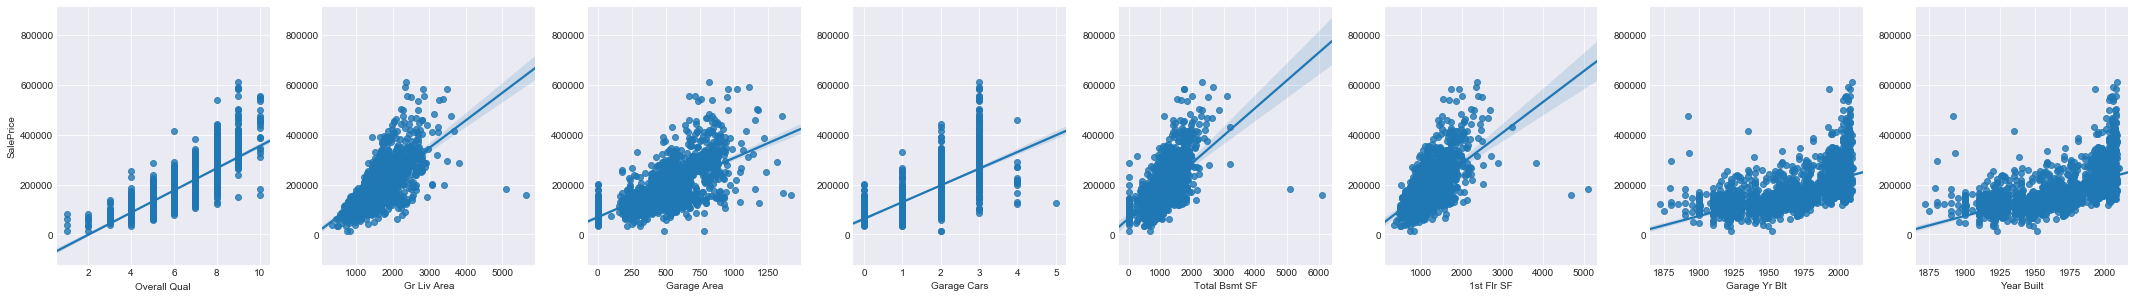

In [19]:
g= sns.pairplot(train_df[['SalePrice','Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',\
       'Total Bsmt SF', '1st Flr SF', 'Garage Yr Blt', 'Year Built']],
             y_vars = ['SalePrice'],
             x_vars = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',\
       'Total Bsmt SF', '1st Flr SF', 'Garage Yr Blt', 'Year Built'],
             kind = 'reg')

g.fig.set_size_inches(30,5)

## Regression Challenge

In [20]:
predictors = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',\
       'Total Bsmt SF', '1st Flr SF', 'Garage Yr Blt', 'Year Built']

X = train_df[predictors]
y = train_df['SalePrice']

#should this be straitfied?
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

model = LinearRegression()

model.fit(X_scaled, y_train)

y_train_predict = model.predict(X_scaled)
y_test_predict = model.predict(X_test_scaled)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test)

(0.7767654097391925, 0.81132888185953811)

In [21]:
cross_val_score(model, X_scaled, y_train, cv = 5).mean()

0.76450458464741433

Text(0,0.5,'Test Values (SalePrice)')

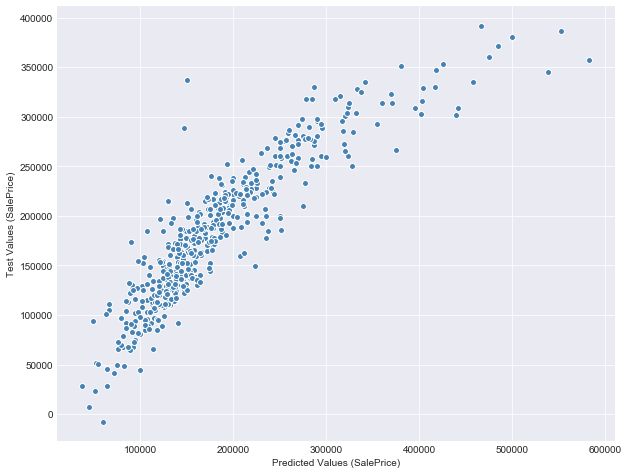

In [22]:
plt.figure(figsize = (10,8))
plt.scatter(y_test, y_test_predict, 
            c='steelblue', marker = 'o', edgecolor = 'white', label = 'Training data')
plt.xlabel('Predicted Values (SalePrice)')
plt.ylabel('Test Values (SalePrice)')

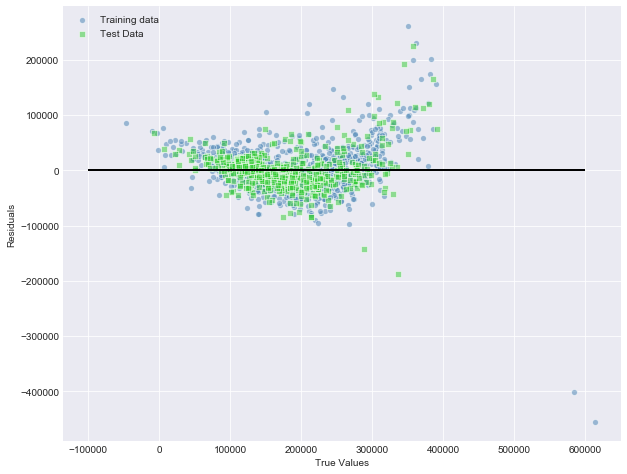

In [23]:
plt.figure(figsize = (10,8))
plt.scatter(y_train_predict, y_train - y_train_predict,
            c='steelblue', marker = 'o', edgecolor = 'white', label = 'Training data', alpha =0.5)
plt.scatter(y_test_predict, y_test - y_test_predict,
           c='limegreen', marker = 's', edgecolor = 'white', label = 'Test Data', alpha = 0.5)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y=0, xmin = -100000, xmax =600000, color = 'black', lw=2)
plt.show()

In [24]:
#Looking at the residuals of just the numerical data, there are a few outliers that area ffecting the model.
# However, just cutting them all out may affect our model's predictive power.  It'll be necessary to explore
# the outliers some more.

#Also, based off the coefs from the LR model, let's remove Garage Year Built and Yr Built. They're the same anyway.

In [25]:
pd.DataFrame({
    "X":predictors,
    "coefs": np.ravel(model.coef_)
})

,X,coefs
0,Overall Qual,32382.229366
1,Gr Liv Area,21183.529009
2,Garage Area,6358.257735
3,Garage Cars,4874.470389
4,Total Bsmt SF,5886.008958
5,1st Flr SF,7124.211890
6,Garage Yr Blt,4506.841477
7,Year Built,4506.841477


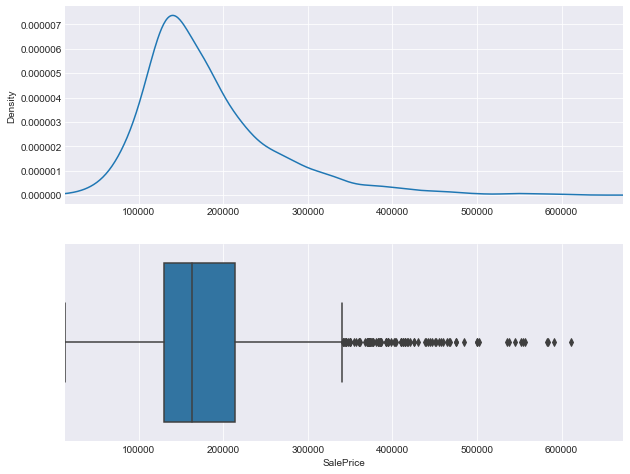

In [26]:
var = train_df['SalePrice']

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(var.min(), var.max()*1.1)
 
ax = var.plot(kind='kde')
 
plt.subplot(212)
plt.xlim(var.min(), var.max()*1.1)
sns.boxplot(x=var, orient = 'h')

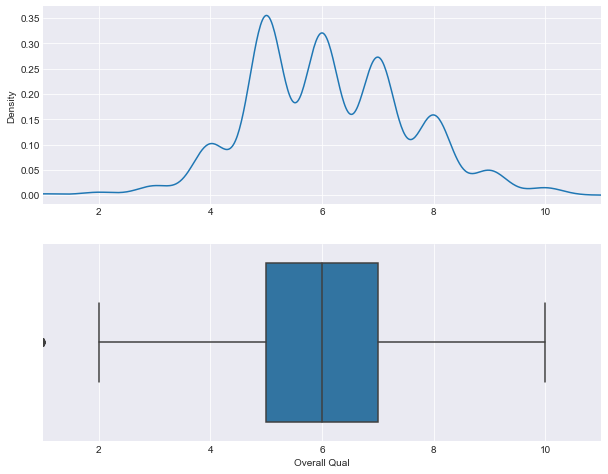

In [27]:
# Starting from the top of the list, looking for outliers:
var = train_df['Overall Qual']

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(var.min(), var.max()*1.1)
 
ax = var.plot(kind='kde')
 
plt.subplot(212)
plt.xlim(var.min(), var.max()*1.1)
sns.boxplot(x=var, orient = 'h')

#This is an ordinal category, makes sense that there aren't any outlers.

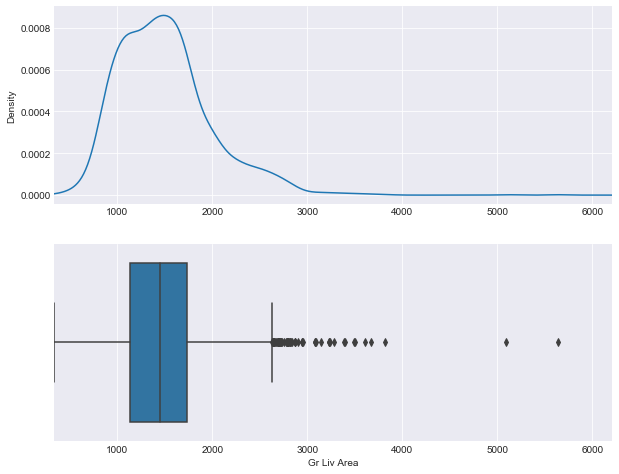

In [28]:
var = train_df['Gr Liv Area']

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(var.min(), var.max()*1.1)
 
ax = train_df['Gr Liv Area'].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(var.min(), var.max()*1.1)
sns.boxplot(x=var, orient = 'h')

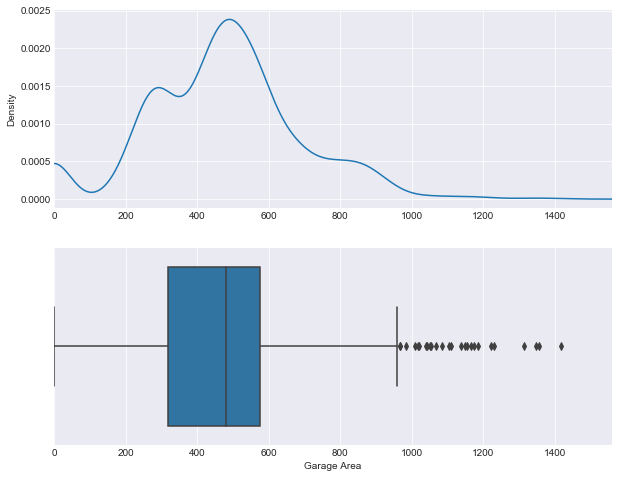

In [29]:
var = train_df['Garage Area']

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(var.min(), var.max()*1.1)
 
ax = var.plot(kind='kde')
 
plt.subplot(212)
plt.xlim(var.min(), var.max()*1.1)
sns.boxplot(x=var, orient = 'h')

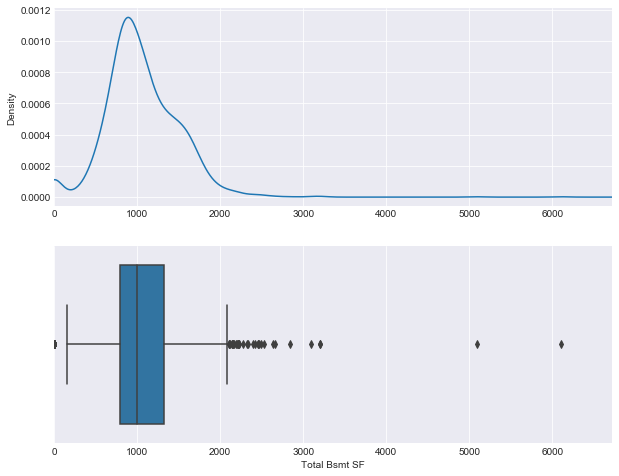

In [30]:
var = train_df['Total Bsmt SF']

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(var.min(), var.max()*1.1)
 
ax = var.plot(kind='kde')
 
plt.subplot(212)
plt.xlim(var.min(), var.max()*1.1)
sns.boxplot(x=var, orient = 'h')

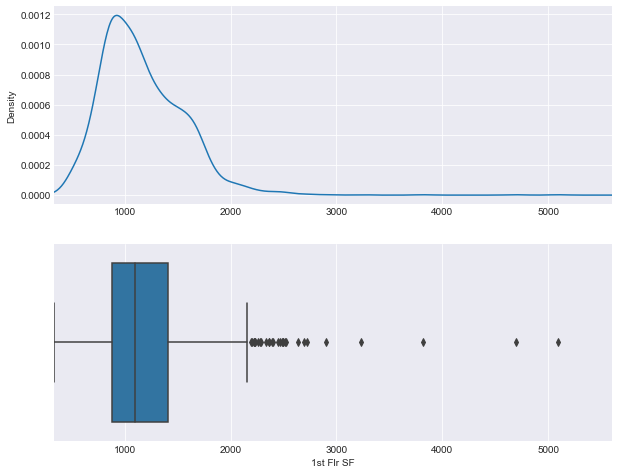

In [31]:
var = train_df['1st Flr SF']

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(var.min(), var.max()*1.1)
 
ax = var.plot(kind='kde')
 
plt.subplot(212)
plt.xlim(var.min(), var.max()*1.1)
sns.boxplot(x=var, orient = 'h')

In [32]:
# As it is now, we can see that many points for our strongest predicts lie outside of the whiskers of these box
# plots.  However, omitting them using the 1.5*IQR and 3.0*IQR rules lowers our predictive power when running
# models without the outliers. I manually removed only the moved extreme values from these variables, being 
# careful not to remove too much information from my strongest predictors!

#Note that I only did this for the continuous variables.

#Also note that we don't want to remove outliers based on SalePrice, that's our target!

new_outlier_train = train_df.loc[~(
    (train_df['Gr Liv Area'] > 5000) |
    (train_df['Garage Area'] > 1200) |
    (train_df['Total Bsmt SF'] > 3000) |
    (train_df['1st Flr SF'] > 3000)),:
]
print(train_df.shape)
print(new_outlier_train.shape)

(2051, 81)
(2040, 81)


In [33]:
predictors = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',\
       'Total Bsmt SF', '1st Flr SF', 'Year Built']

X = new_outlier_train[predictors]
y = new_outlier_train['SalePrice']

#should this be straitfied?
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

model = LinearRegression()

model.fit(X_scaled, y_train)

y_train_predict = model.predict(X_scaled)
y_test_predict = model.predict(X_test_scaled)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test)

(0.8192130269846335, 0.83435560480955373)

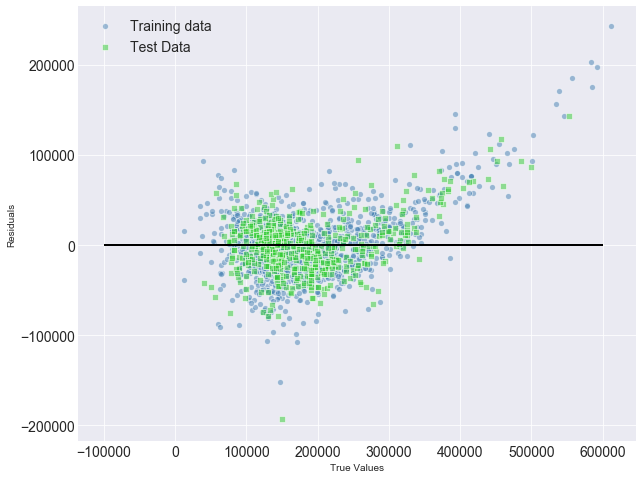

In [34]:
#Residuals, using code from Packt ML book.
plt.figure(figsize = (10,8))
plt.scatter(y_train,y_train-y_train_predict,
            c='steelblue', marker = 'o', edgecolor = 'white', label = 'Training data', alpha =0.5)
plt.scatter(y_test,  y_test - y_test_predict,
           c='limegreen', marker = 's', edgecolor = 'white', label = 'Test Data', alpha = 0.5)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left', fontsize = 14)
plt.tick_params(axis='both', labelsize = 14)
plt.hlines(y=0, xmin = -100000, xmax =600000, color = 'black', lw=2)
plt.show()

In [35]:
# There are still some large residuals for predicted values above $300,000, but that makes sense 
# that unusually high or low SalePrices are anomalous and will have more error.
# Hwoever, we did manage to remove the most extreme residuals.

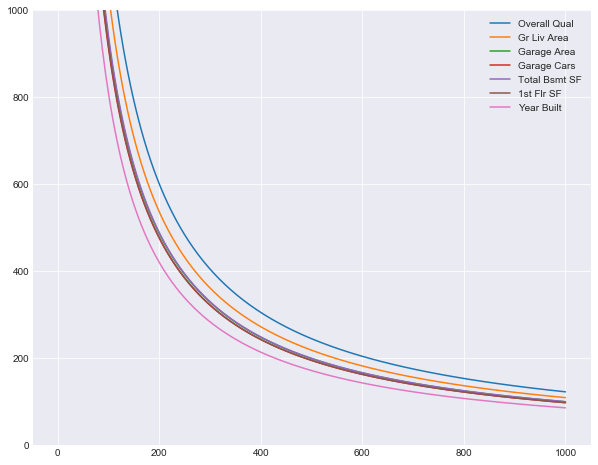

In [36]:
alpha_list = np.logspace(0, 3, 200)
coefs_list = []
for i in alpha_list:
    model = ElasticNet(alpha = i)
    model.fit(X_scaled, y_train)
    coefs_list.append(model.coef_)
    
plt.figure(figsize = (10,8))
plt.plot(alpha_list, coefs_list);
plt.ylim(0,1000)
plt.legend(predictors)

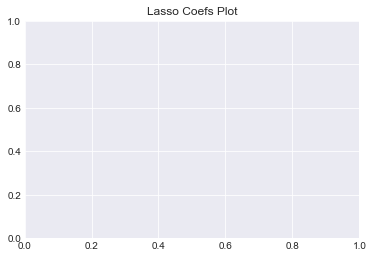

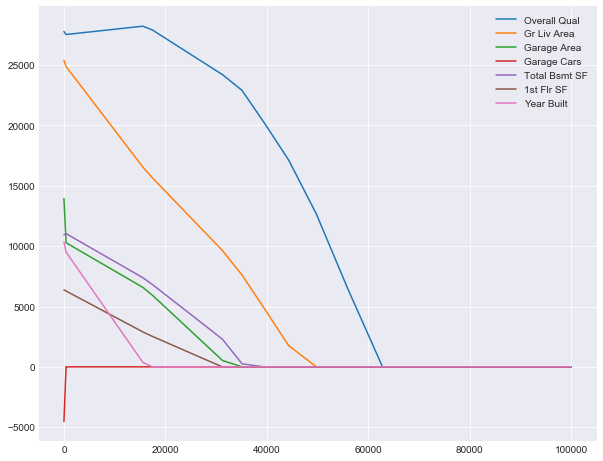

In [37]:
alpha_list = np.logspace(0, 5, 100)
coefs_list = []
for i in alpha_list:
    model = Lasso(alpha = i)
    model.fit(X_scaled, y_train)
    coefs_list.append(model.coef_)
    
plt.title('Lasso Coefs Plot')
plt.figure(figsize = (10,8))
plt.plot(alpha_list, coefs_list);
plt.legend(predictors)

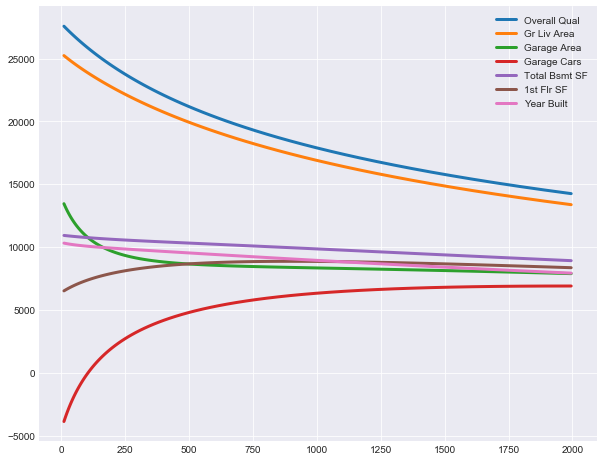

In [38]:
alpha_list = np.logspace(1, 3.3, 100)
coefs_list = []
for i in alpha_list:
    model = Ridge(alpha = i)
    model.fit(X_scaled, y_train)
    coefs_list.append(model.coef_)
    
plt.figure(figsize = (10,8))
plt.plot(alpha_list, coefs_list, lw = '3');
plt.legend(predictors)

In [39]:
model = LassoCV(alphas=np.linspace(0.001, 100, 1000), cv = 10, max_iter = 100000)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test), model.alpha_

(0.81921302556682751, 0.83435831088452717, 0.60159459459459463)

In [40]:
model = RidgeCV(alphas=np.linspace(0.001, 100, 100), cv = 10)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test), model.alpha_

(0.81907648690134405, 0.83520276275968697, 27.273454545454548)

In [41]:
model = ElasticNetCV(l1_ratio = [.01, .1, .5, .7, .9, .95, .99, 1], alphas=np.linspace(0.001, 10, 1000), cv = 5)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test),model.alpha_, model.l1_ratio_

(0.81916714445950456,
 0.83487880197293252,
 0.011009009009009009,
 0.10000000000000001)

In [42]:
# From this, it looks like my top predictors score slightly better using ridge.  ElasticNetCV is very
# sensitive to the alpha range specified and gives different l1_ratios depending on how it's crossvalidated.
# Based on the alpha plots and the nature of the Ames data, I'm going to use Ridge to base by optimization on,
# since I think it'll be valuable to mantain the smaller contribution of the weaker variables.

In [43]:
#Re-optimizing alpha
model = RidgeCV(alphas=np.linspace(0.1, 100, 1000), cv = 5)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test), model.alpha_

(0.8191645948309717, 0.83489190854530171, 15.6)

In [44]:
pd.DataFrame({
    "X":predictors,
    "coefs": np.ravel(model.coef_)}).sort_values(by = 'coefs',ascending = False)

,X,coefs
0,Overall Qual,27458.872873
1,Gr Liv Area,25143.398798
2,Garage Area,13193.827146
4,Total Bsmt SF,10909.564388
6,Year Built,10288.432980
5,1st Flr SF,6576.775636
3,Garage Cars,-3552.499634


In [45]:
# Now that we have our strongest features we calculated using Ridge, let's try plugging it in to a
# KNN Regressor, optimizing via GridSearch.

In [46]:
predictors = ['Overall Qual', 'Gr Liv Area', 'Garage Area', \
       'Total Bsmt SF', '1st Flr SF','Year Built']

X = new_outlier_train[predictors]
y = new_outlier_train['SalePrice']

X_train, X_hold, y_train, y_hold = train_test_split(X,y,test_size = 0.25, random_state = 1)

ss = StandardScaler()
knn = KNeighborsRegressor()

pipe = Pipeline([ 
    ('ss', ss),                                
    ('knn', knn)                               
    
])

params = {
    'knn__n_neighbors': range(1,21),
    'knn__p': [1,2],
    'knn__weights' : ['uniform', 'distance'],
    'knn__algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute']
}
gs = GridSearchCV(pipe, param_grid = params, cv =5, n_jobs = -1)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)
gs.score(X_hold, y_hold)

0.864589865666
{'knn__algorithm': 'brute', 'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}


0.87922008171055122

In [47]:
gs.score(X_train, y_train)

0.99976928074067672

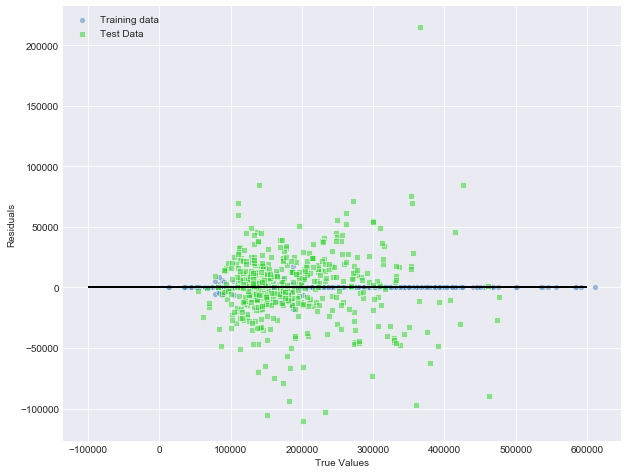

In [48]:
y_train_predict = gs.predict(X_train)
y_test_predict = gs.predict(X_hold)

plt.figure(figsize = (10,8))
plt.scatter(y_train_predict, y_train_predict - y_train,
            c='steelblue', marker = 'o', edgecolor = 'white', label = 'Training data', alpha =0.5)
plt.scatter(y_test_predict, y_test_predict - y_test,
           c='limegreen', marker = 's', edgecolor = 'white', label = 'Test Data', alpha = 0.5)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y=0, xmin = -100000, xmax =600000, color = 'black', lw=2)
plt.show()

In [49]:
# y_hat = gs.predict(X_testdf_scaled)
# test_ids = test_df['Id']

# pd.DataFrame({
#     "Id":test_ids,
#     "SalePrice": y_hat
# }).to_csv('reg_tuned_knn_outliersin_dist_sub5.csv', index = False)


## Regression Model Scores:

- GridSearch Cross-validated R^2 = 86.6%
- X_hold R^2 = 87.8%  (Scored on holdout set of training data).
    - This model produced my 2nd lowest RMSE on Kaggle (RMSE = 38753.19636) 
    
    
- Optimized with:
    - n_neighbors = 9
    - p = 1 (manhattan distance)
    - algorithm = 'brute' (decides automatically, didn't see much of a difference when toggling between kd_tree, ball_tree, and brute)
    - weights = distance (closer points have more influence over neighbors that are further away).
    - Note: These are optimized using random_state = 1.  They change for each different state or if random_state is not specified, choosing a random sample each instance.
    
- It's possible that we're overfitting as KNN tends to do, and maybe by chance got my 2nd best RMSE this way.  The train set residuals are all close to zero (since we scored 0.99 on R^2), but our residuals on predicted X_hold seem to be pretty spread out.

- Now that we've got a decent model just based on the numerical columns in our cleaned data, let's try to
    use our master_train_df that has all of the mapped ordinal categories as well as the dummy columns
    for the nominal categories.
- Considering the funny looking residuals obtained from KNN Regressor, we probably aren't going to do much better by adding more features (I tried and it got worse via the curse of dimensionality), so we're sticking with Ridge for modeling on all of the predictors (numerical, ordinal, and dummies).

In [50]:
# Cutting out the outliers we found earlier:

new_outlier_train = master_train_df.loc[~(
    (train_df['Gr Liv Area'] > 5000) |
    (train_df['Garage Area'] > 1200) |
    (train_df['Total Bsmt SF'] > 3000) |
    (train_df['1st Flr SF'] > 3000)),:
]
print(master_train_df.shape)
print(new_outlier_train.shape)

(2051, 256)
(2040, 256)


In [51]:
# Gathering all of our predictor columns except for SalePrice.

predictors = [col for col in list(new_outlier_train.columns) if col != "SalePrice"]

X = new_outlier_train[predictors]
y = new_outlier_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

model = RidgeCV(alphas=np.linspace(100,200,100), cv = 3)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test), model.alpha_

(0.92873616404171522, 0.91814670720297575, 178.78787878787881)

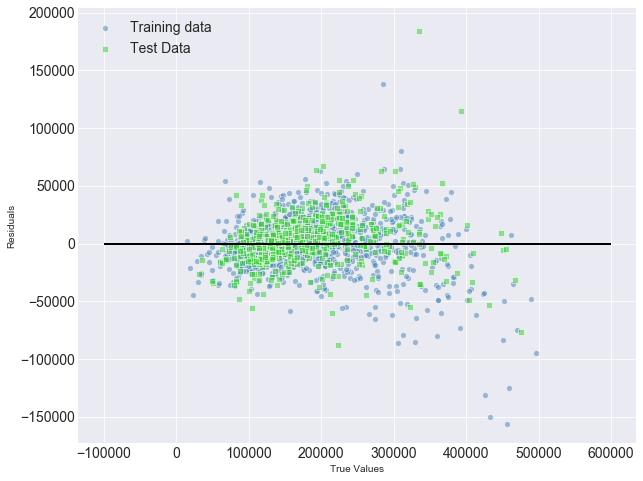

In [52]:
y_train_predict = model.predict(X_scaled)
y_test_predict = model.predict(X_test_scaled)

plt.figure(figsize = (10,8))
plt.scatter(y_train_predict, y_train_predict - y_train,
            c='steelblue', marker = 'o', edgecolor = 'white', label = 'Training data', alpha =0.5)
plt.scatter(y_test_predict, y_test_predict - y_test,
           c='limegreen', marker = 's', edgecolor = 'white', label = 'Test Data', alpha = 0.5)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left', fontsize = 14)
plt.tick_params(axis='both', labelsize = 14)
plt.hlines(y=0, xmin = -100000, xmax =600000, color = 'black', lw=2)
plt.show()

- These numbers are improved, but looking suspiciously like an overfit.  However, we can still look at the
    values of the coefficients and select features.

In [53]:
test_coefs = pd.DataFrame({
    "feature":list(X.columns),
    "coefs":abs(model.coef_)}).sort_values(by = 'coefs',ascending=False)

test_coefs

,coefs,feature
28,10937.451077,Gr Liv Area
7,9845.615094,Overall Qual
25,8299.324244,1st Flr SF
18,6317.422722,BsmtFin SF 1
11,6198.199055,Mas Vnr Area
22,6022.972616,Total Bsmt SF
158,5814.073199,Neighborhood_NridgHt
164,5589.233225,Neighborhood_StoneBr
26,5169.546781,2nd Flr SF
43,4890.374305,Garage Area


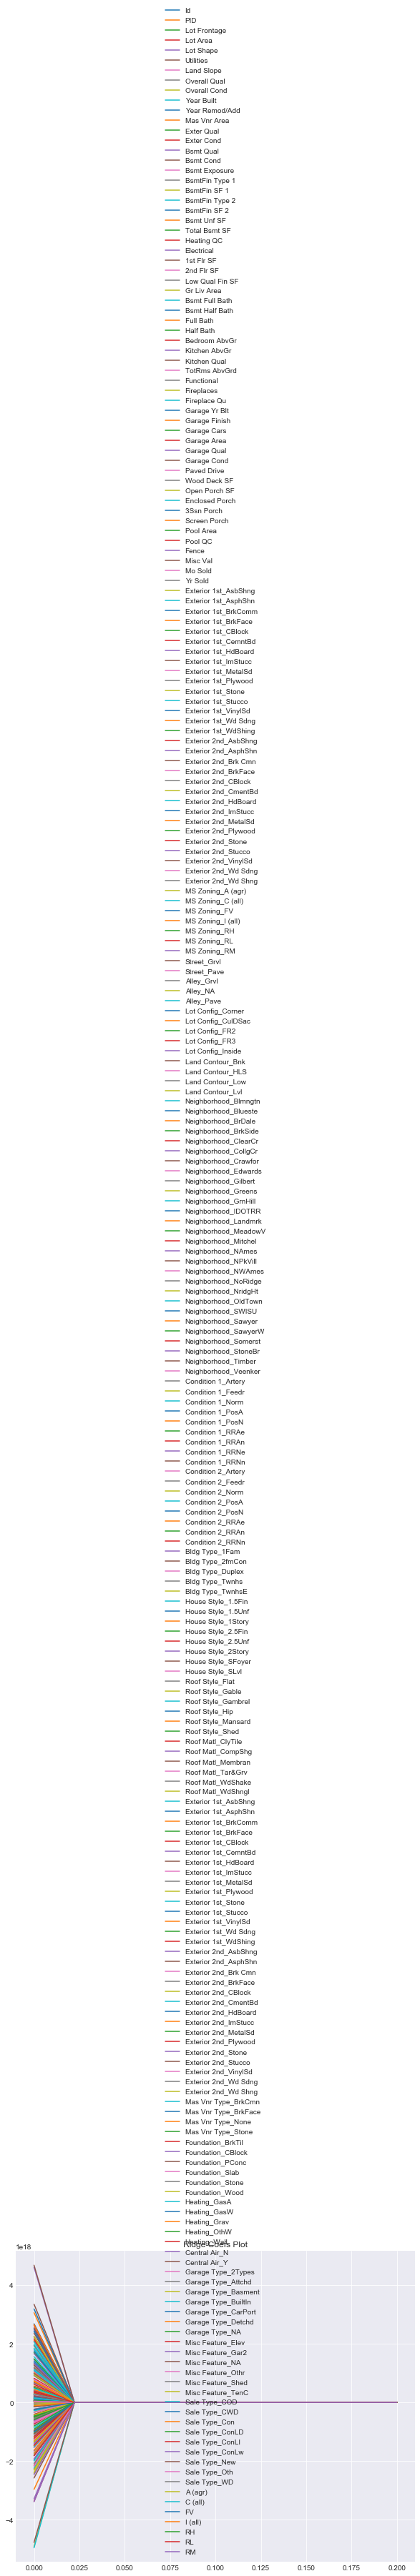

In [54]:
alpha_list = np.linspace(0, 0.2, 10)
coefs_list = []
for i in alpha_list:
    model = Ridge(alpha = i)
    model.fit(X_scaled, y_train)
    coefs_list.append(model.coef_)
    

plt.figure(figsize = (10,8))
plt.plot(alpha_list, coefs_list);
plt.title('Ridge Coefs Plot')
plt.legend(predictors)

- Again, it looks like our strongest predictors are Gr Liv Area, Overall Qual, and 1st Flr SF.  However, it looks like Year Built mattered less here, and the model is showing that Mas Vnr Area is the 5th strongest feature, as well as if the house belonged to the neighborhoods of NrdgeHt of StoneBr.  Other features that we could intuitively expect to matter as well as the 2nd Flr SF and Garage Area, basically more metrics for how large the home is.

- I arbitrarily cut down on these features, choosing the variables that had coefs > 1000, then applied the Ridge model.

In [55]:
predictors = test_coefs.loc[test_coefs['coefs'] > 1000, :]['feature'].tolist()

X = new_outlier_train[predictors]
y = new_outlier_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

model = Ridge(alpha = 150.50505050505052, max_iter = 10000, tol = 0.001)

model.fit(X_scaled, y_train)

y_train_predict = model.predict(X_scaled)
y_test_predict = model.predict(X_test_scaled)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test)

(0.92933505114424997, 0.91740292713216653)

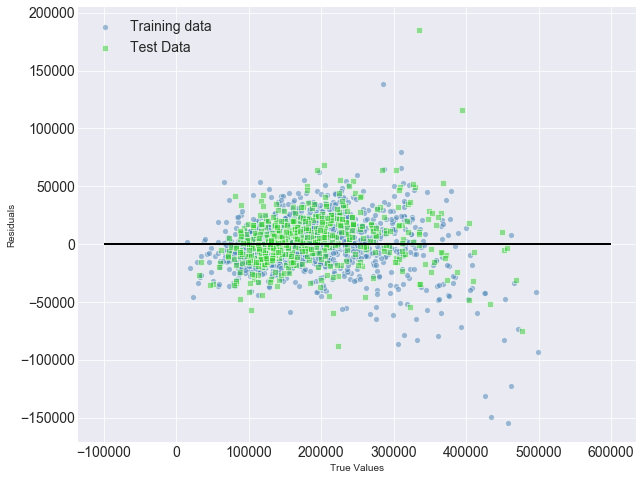

In [56]:
y_train_predict = model.predict(X_scaled)
y_test_predict = model.predict(X_test_scaled)

plt.figure(figsize = (10,8))
plt.scatter(y_train_predict, y_train_predict - y_train,
            c='steelblue', marker = 'o', edgecolor = 'white', label = 'Training data', alpha =0.5)
plt.scatter(y_test_predict, y_test_predict - y_test,
           c='limegreen', marker = 's', edgecolor = 'white', label = 'Test Data', alpha = 0.5)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left', fontsize = 14)
plt.tick_params(axis='both', labelsize = 14)
plt.hlines(y=0, xmin = -100000, xmax =600000, color = 'black', lw=2)
plt.show()

In [61]:
test_coefs['feature'].tolist()[:]

['Gr Liv Area',
 'Overall Qual',
 '1st Flr SF',
 'BsmtFin SF 1',
 'Mas Vnr Area',
 'Total Bsmt SF',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 '2nd Flr SF',
 'Garage Area']

In [104]:
poly = PolynomialFeatures(degree = 2)

poly.fit_transform(X_train)[0][-10:]

array([ 4.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.])

In [88]:
X_train.head()

,Gr Liv Area,Overall Qual,1st Flr SF,BsmtFin SF 1,Mas Vnr Area,Total Bsmt SF,Neighborhood_NridgHt,Neighborhood_StoneBr,2nd Flr SF,Garage Area,...,Heating_OthW,Sale Type_Con,Roof Matl_Membran,Bsmt Unf SF,Condition 2_PosA,Neighborhood_BrDale,Utilities,Foundation_CBlock,Neighborhood_Crawfor,Neighborhood_SawyerW
466,1721,6,936,814.0,105.0,928.0,0,0,785,471.0,...,0,0,0,114.0,0,0,2,0,0,1
1965,2640,5,1392,1018.0,0.0,2171.0,0,0,1248,1008.0,...,0,0,0,1153.0,0,0,2,1,0,0
509,2713,9,1476,1330.0,268.0,1452.0,1,0,1237,858.0,...,0,0,0,122.0,0,0,2,0,0,0
1428,334,1,334,0.0,0.0,0.0,0,0,0,0.0,...,0,0,0,0.0,0,0,2,0,0,0
1738,864,5,864,775.0,0.0,864.0,0,0,0,280.0,...,0,0,0,89.0,0,0,2,1,0,0


In [109]:
X_train.iloc[1,-20:]

Neighborhood_Gilbert       0.0
Condition 1_RRAe           0.0
Garage Cars                3.0
Bsmt Full Bath             2.0
Mas Vnr Type_BrkCmn        0.0
Roof Style_Hip             0.0
BsmtFin Type 1             6.0
Mas Vnr Type_None          1.0
Lot Config_FR3             0.0
Open Porch SF             48.0
Heating_OthW               0.0
Sale Type_Con              0.0
Roof Matl_Membran          0.0
Bsmt Unf SF             1153.0
Condition 2_PosA           0.0
Neighborhood_BrDale        0.0
Utilities                  2.0
Foundation_CBlock          1.0
Neighborhood_Crawfor       0.0
Neighborhood_SawyerW       0.0
Name: 1965, dtype: float64

4900

In [111]:
predictors = test_coefs.loc[test_coefs['coefs'] > 1000, :]['feature'].tolist()

X = new_outlier_train[predictors]
y = new_outlier_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
poly = PolynomialFeatures(degree = 2)
ridge = Ridge(alpha = 150, max_iter = 10000, tol = 0.001)

pipe = Pipeline([ 
    ('poly', poly),
    ('ss', ss),                                
    ('ridge', ridge)                               
    
])

params = {

    
}

gs = GridSearchCV(pipe, param_grid = params, cv =3, n_jobs = 2)
gs.fit(X_train, y_train)


print(gs.best_score_)
print(gs.best_params_)
gs.score(X_train, y_train), gs.score(X_test, y_test)

0.918769699244
{}


(0.97317875858469471, 0.92464215162488861)

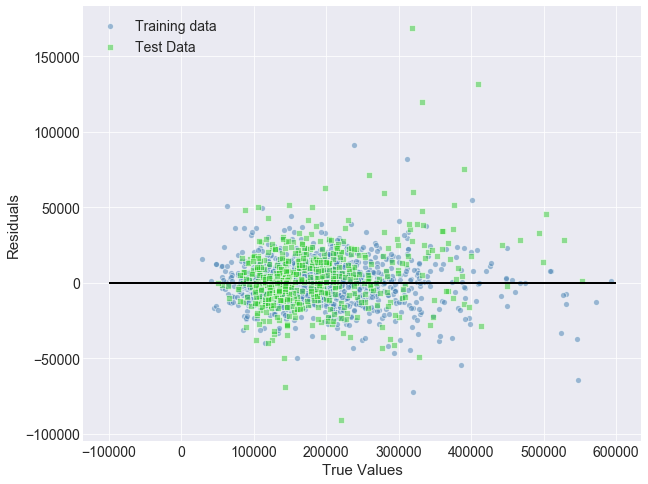

In [79]:
y_train_predict = gs.predict(X_train)
y_test_predict = gs.predict(X_test)

plt.figure(figsize = (10,8))
plt.scatter(y_train_predict, y_train_predict - y_train,
            c='steelblue', marker = 'o', edgecolor = 'white', label = 'Training data', alpha =0.5)
plt.scatter(y_test_predict, y_test_predict - y_test,
           c='limegreen', marker = 's', edgecolor = 'white', label = 'Test Data', alpha = 0.5)
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Residuals', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 14)
plt.tick_params(axis='both', labelsize = 14)
plt.hlines(y=0, xmin = -100000, xmax =600000, color = 'black', lw=2)
plt.show()

In [1]:
# X_testdf_dummies = pd.get_dummies(test_df[['Neighborhood','Bldg Type','Sale Type','Roof Matl',
#                                           'Garage Type','Lot Config','Land Contour','Foundation',
#                                           'Condition 1','Condition 2','Roof Style','House Style']])

# X_testdf_numeric = test_df[['Gr Liv Area',
#                              'Overall Qual',
#                              '1st Flr SF',
#                              'Total Bsmt SF',
#                              'BsmtFin SF 1',
#                              '2nd Flr SF',
#                              'Mas Vnr Area',
#                              'Exter Qual',
#                              'Kitchen Qual',
#                              'Overall Cond',
#                              'Lot Area',
#                              'Garage Area',
#                              'Bsmt Qual',
#                              'Functional',
#                              'Bsmt Exposure',
#                              'TotRms AbvGrd',
#                              'Garage Yr Blt',
#                              'Year Built',
#                              'Screen Porch',
#                              'Garage Cars',
#                              'Full Bath',
#                              'Half Bath',
#                              'Wood Deck SF',
#                              'Fireplaces',
#                              'BsmtFin SF 2',
#                              'Bsmt Full Bath',
#                              'Year Remod/Add',
#                              'Fireplace Qu',
#                              'BsmtFin Type 1',
#                              'Paved Drive',
#                              'Garage Finish',
#                              'Garage Qual',
#                              'Lot Frontage',
#                              'Pool QC']]

# X_testdf_dummies['Neighborhood_GrnHill'] = np.zeros(shape=len(X_testdf_dummies))

# X_testdf_con = pd.concat([X_testdf_numeric,X_testdf_dummies], axis = 1)
# X_testdf = X_testdf_con[predictors]
# print(X_testdf.shape)

# poly = PolynomialFeatures(degree = 2, include_bias=True)  
# ss = StandardScaler()

# X_testdf_poly = poly.fit_transform(X_testdf)
# X_testdf_scaled = ss.fit_transform(X_testdf_poly)


# y_hat = gs.predict(X_testdf_scaled) 

# test_ids = test_df['Id']

# pd.DataFrame({
#     "Id":test_ids,
#     "SalePrice": y_hat
# }).to_csv('reg_ridge_gs_dummies_late.csv', index = False)

- The score improved slightly by cutting down on the features.  However, after trying with the top 40, 30, 20, and 10 features from this list yielded lower and lower R^2 scores, and subsequently worse RMSE.  Just using the top 54, however, gave me my top score on Kaggle (38679.11663).


- Unfortunately, this is where I ran out of submissions.  I'm curious to see what would happen if I kept in my negative coefs as part of the top 54, since a few of them had absolute values in the 3000's, whereas I kept some positive features as low as 1001.


- Of the most negative coefs, the 'negative' predictors on Sale Price were neighoborhoods North Ames, College Creek, and Northwest Ames. Townhouse-type homes were cheaper, as well as having fewer 2nd+ story bedrooms or not having a 2nd story kitchen lowered the SalePrice.  Court Ordered Deed sales and Warranty Deed sales also indicated lower sale prices.


- Alpha is found to be fairly high (150 - 200) when using more features, which suggests that the model is trying to eliminate/lessen the contribution of more "weak" features.  Earlier, I thought that maybe keeping the weaker features could improve the prediction accuracy since this is such a high dimensional dataset, but so far we've just run the risk of overfitting or wrecking our R^2 scores.  It could be worth it to revisit this method focusing more on Lasso.

Below is an example Pipeline + GridSearch I used to do this project.  However, I found that most of these different settings either caused more overfitting (i.e poly degree = 2 or 3), or didn't seem to make much of a difference for ridge and lasso.  However,I did use this build to optimize KNN parameters.

In [ ]:
# ss = StandardScaler()
# ridge = Ridge(max_iter = 10000, tol = 0.001)
# poly = PolynomialFeatures()
# lasso = Lasso(max_iter = 10000, tol = 0.001)


# pipe = Pipeline([ 
#     ('poly', poly),
#     ('ss', ss),
#     ('lasso', lasso),
#     ('ridge', ridge)
#     ('knn', knn)
    
# ])

# params = {
    
#     'poly__degree': [1,2,3],
#     'poly__interaction__only': [True,False]
#     'poly__include_bias': [True, False]
    
    
#     'lasso__alpha' : np.linspace(50, 500, 50),
#     'lasso__fit_intercept' : [True, False],
#     'lasso__normalize' : [True, False],
#     'lasso__positive' : [True, False],
#     'lasso__selection' : ['random','cyclic'],
    
#     'ridge__alpha' : np.linspace(50, 500, 50),
#     'ridge__fit_intercept' : [True, False],
#     'ridge__normalize' : [True, False]
    
#     'knn__n_neighbors': range(1,21),
#     'knn__p': [1,2],
#     'knn__weights' : ['uniform', 'distance'],
#     'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
    
# }

# gs = GridSearchCV(pipe, param_grid = params, cv =3, n_jobs = -1)   #remember, cv = 3 by default
# gs.fit(X, y)

# print(gs.best_score_)
# print(gs.best_params_)
# print(gs.best_estimator_)
# gs.score(X, y)

- Exported the csv, accounted for the mismatched columns labels:


- Note: My export code isn't very D.R.Y., but I picked out the columns manually to make sure I knew what columns I needed in my model from the test set to gain a sense of what values/columns were mismatched.

In [ ]:
# X_testdf_dummies = pd.get_dummies(test_df[['Neighborhood','Bldg Type','Sale Type','Roof Matl',
#                                           'Garage Type','Lot Config','Land Contour','Foundation',
#                                           'Condition 1','Condition 2','Roof Style','House Style']])

# X_testdf_numeric = test_df[['Gr Liv Area',
#                              'Overall Qual',
#                              '1st Flr SF',
#                              'Total Bsmt SF',
#                              'BsmtFin SF 1',
#                              '2nd Flr SF',
#                              'Mas Vnr Area',
#                              'Exter Qual',
#                              'Kitchen Qual',
#                              'Overall Cond',
#                              'Lot Area',
#                              'Garage Area',
#                              'Bsmt Qual',
#                              'Functional',
#                              'Bsmt Exposure',
#                              'TotRms AbvGrd',
#                              'Garage Yr Blt',
#                              'Year Built',
#                              'Screen Porch',
#                              'Garage Cars',
#                              'Full Bath',
#                              'Half Bath',
#                              'Wood Deck SF',
#                              'Fireplaces',
#                              'BsmtFin SF 2',
#                              'Bsmt Full Bath',
#                              'Year Remod/Add',
#                              'Fireplace Qu',
#                              'BsmtFin Type 1',
#                              'Paved Drive',
#                              'Garage Finish',
#                              'Garage Qual',
#                              'Lot Frontage',
#                              'Pool QC']]

# X_testdf_dummies['Neighborhood_GrnHill'] = np.zeros(shape=len(X_testdf_dummies))

# X_testdf_con = pd.concat([X_testdf_numeric,X_testdf_dummies], axis = 1)
# X_testdf = X_testdf_con[best_preds]
# print(X_testdf.shape)

# poly = PolynomialFeatures(degree = 2, include_bias=True)  
# ss = StandardScaler()

# X_testdf_poly = poly.fit_transform(X_testdf)
# X_testdf_scaled = ss.fit_transform(X_testdf_poly)


# y_hat = model.predict(X_testdf_scaled) 

# test_ids = test_df['Id']

# pd.DataFrame({
#     "Id":test_ids,
#     "SalePrice": y_hat
# }).to_csv('reg_ridge_gs_dummies_sub13.csv', index = False)

## Classification

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
train_df = pd.read_csv('train.csv')

sale_cond_maps = {
    "Normal" : 0,
    "Partial": 1,
    "Abnorml" : 1,
    "Family": 1,
    "Alloca": 1,
    "AdjLand":1
}

target_sale_condition = train_df['Sale Condition'].map(sale_cond_maps)

train_df.drop('Sale Condition', axis = 1, inplace = True)

Master_df()

master_train_df['Sale Condition'] = target_sale_condition

# DataCleaner(train_df)
new_outlier_train = master_train_df.loc[~(
    (train_df['Gr Liv Area'] > 5000) |
    (train_df['Garage Area'] > 1200) |
    (train_df['Total Bsmt SF'] > 3000) |
    (train_df['1st Flr SF'] > 3000)),:
]
print(master_train_df.shape)
print(new_outlier_train.shape)

In [ ]:
master_train_df['Sale Condition'].value_counts()

In [ ]:
'SaleCondition' in predictors

In [ ]:
predictors = list(set(new_outlier_train.columns) - {'Sale Condition', 'SalePrice'})

X = new_outlier_train[predictors]
y = new_outlier_train['Sale Condition']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

logreg = LogisticRegressionCV(Cs = np.linspace(0.001,1,100), cv = 3)
logreg.fit(X_scaled, y_train)

logreg.score(X_scaled, y_train),logreg.score(X_test_scaled, y_test), logreg.C_[0]

- The regularization strength is pretty high (C is low, 1/C ~ 17), but it's not as high as the alphas we saw with the regression models.  It might be better in this case to keep more features.

In [ ]:
logreg_stats = pd.DataFrame({
    "feature":list(X.columns),
    "coefs":(np.ravel(logreg.coef_))})

logreg_stats.sort_values(by = 'coefs', ascending=False)

In [ ]:
logreg_stats.sort_values(by = 'coefs', ascending=True)

In [ ]:
logreg_stats = pd.DataFrame({
    "feature":list(X.columns),
    "coefs":(np.abs(np.ravel(logreg.coef_)))})

logreg_sorted = logreg_stats.sort_values(by = 'coefs', ascending=False)

In [ ]:
logreg_sorted['feature'].tolist()[0:10]

In [ ]:
# It looks like the best predictors are as follows, let's try them:

In [ ]:
predictors = logreg_sorted['feature'].tolist()[0:15]

X = new_outlier_train[predictors]
y = new_outlier_train['Sale Condition']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

logreg = LogisticRegressionCV(Cs = np.linspace(0.001,1,100), cv = 3)
logreg.fit(X_scaled, y_train)


logreg.score(X_scaled, y_train),logreg.score(X_test_scaled, y_test), logreg.C_[0]

In [ ]:
predictors = logreg_sorted['feature'].tolist()

X = new_outlier_train[predictors]
y = new_outlier_train['Sale Condition']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

logreg = LogisticRegressionCV(Cs = np.linspace(0.001,1,100), cv = 3)
logreg.fit(X_scaled, y_train)


logreg.score(X_scaled, y_train),logreg.score(X_test_scaled, y_test), logreg.C_[0]

- It looks like we got a bit more accuracy with more features.  Considering C is farily low, let's go ahead and keep as they might contribute to the predictive power of our classifier.

- Let's recall what the baseline probability is.  Just from the value counts, our probability baseline is ~82.7% chance of being "normal" sale, ~17.3% of being "abnormal."

In [ ]:
master_train_df['Sale Condition'].value_counts(normalize = True)

In [ ]:
master_train_df['Sale Condition'].value_counts()

In [ ]:
probas = pd.DataFrame(data = logreg.predict_proba(X_test_scaled), columns = ['P(Normal)', 'P(Abnormal)'])

In [ ]:
probas.shape

In [ ]:
logreg.predict(X_test_scaled).shape

In [ ]:
probas['prediction'] = logreg.predict(X_test_scaled)

In [ ]:
probas

In [ ]:
y_hat = logreg.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_hat)
display(cm)

tp_r = cm[1,1]
fp_r = cm[0,1]

tn_r = cm[0,0]
fn_r = cm[1,0]

display(pd.DataFrame({
    "Predicted Neg (0) ":[tn_r,fn_r],
    "Predicted Pos (1)":[fp_r,tp_r]}, index = ["Actual Neg (0)", 'Actual Pos (1)']))

Getting a lot of false negatives, going to optimize using gridsearch, then modify threshold.

In [ ]:
predictors = logreg_sorted['feature'].tolist()[0:15]

X = new_outlier_train[predictors]
y = new_outlier_train['Sale Condition']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=1)

ss = StandardScaler()
logreg = LogisticRegression(penalty = 'l2',max_iter = 10000)

pipe = Pipeline([ 
    ('ss', ss),
    ('logreg',logreg)
])

params = {
    "logreg__solver": ['newton-cg', 'lbfgs', 'sag'],
    "logreg__C": np.linspace(0.001,1,100)
}

gs = GridSearchCV(pipe, param_grid = params, cv =3, n_jobs = -1)   #remember, cv = 3 by default
gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)
gs.score(X_train, y_train), gs.score(X_test, y_test)

In [ ]:
y_hat = gs.predict(X_test)

cm = confusion_matrix(y_test, y_hat)
display(cm)

tp_r = cm[1,1]
fp_r = cm[0,1]

tn_r = cm[0,0]
fn_r = cm[1,0]

display(pd.DataFrame({
    "Predicted Neg (0) ":[tn_r,fn_r],
    "Predicted Pos (1)":[fp_r,tp_r]}, index = ["Actual Neg (0)", 'Actual Pos (1)']))

In [ ]:
print("FPR", float(fp_r) / (tn_r + fp_r))
print("TPR", float(tp_r) / (tp_r + fn_r))

In [ ]:
test_df.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, gs.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for Sale Prediction (Normal =0, Abnormal =1)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

- This model is predicting quite a few false negatives, about half of them are wrong (TPR ~ 50%).  We need to adjust our threshold.

- The ROC curve itself is left shifted, and implies that we will have to increase the threshold to predict more true negatives.

In [ ]:
probas = pd.DataFrame(data = gs.predict_proba(X_test), columns = ['P(Normal)', 'P(Abnormal)'])
probas['thresh'] = probas.loc[:,'P(Abnormal)']
probas.head()

In [ ]:
probas['thresh'] = probas['thresh'].map(lambda x: 1 if x >= 0.5 else 0)
probas.head()

In [ ]:
base_fp = probas['thresh'].sum()
base_fp

In [ ]:
t_values = np.arange(0.9,1.0,0.01)

fp_list = [probas['P(Abnormal)'].map(lambda x: 1 if x >= t else 0).sum() for t in t_values]

pd.DataFrame({
    "threshold":t_values,
    "fp count": fp_list
})

In [ ]:
pred_prob = pd.DataFrame(data = gs.predict_proba(X_test), columns = ['P(Normal)', 'P(Abnormal)'])

pred_prob['P(Abnormal)_0.9t'] = pred_prob['P(Abnormal)'].map(lambda x: 1 if x >= 0.98 else 0)

pred_prob

In [ ]:
y_hat = pred_prob['P(Abnormal)_0.9t']
y_hat.sum()

- Looks like we had to crank up our threshold to 0.98 if we wanted to start lowering the false negatives.

In [ ]:
X_testdf_dummies = pd.get_dummies(test_df[['Sale Type','House Style','Lot Config',
                                           'Misc Feature', 'Mas Vnr Type']])

X_testdf_numeric = test_df[['Overall Cond',
                             'BsmtFin Type 1',
                             'Bsmt Cond',
                             'Paved Drive',
                             'TotRms AbvGrd',
                             'Bsmt Exposure',
                             'Lot Shape',
                             'Kitchen Qual',
                             'Bsmt Full Bath']]

X_testdf_con = pd.concat([X_testdf_numeric,X_testdf_dummies], axis = 1)
X_testdf = X_testdf_con[predictors]
print(X_testdf.shape)

In [ ]:
pred_prob = pd.DataFrame(data = gs.predict_proba(X_testdf), columns = ['P(Normal)', 'P(Abnormal)'])

pred_prob['P(Abnormal)_0.9t'] = pred_prob['P(Abnormal)'].map(lambda x: 1 if x >= 0.99 else 0)

pred_prob.head(10)

In [ ]:
y_hat = pred_prob['P(Abnormal)_0.9t']
y_hat.sum()

-  By cranking up the threshold, we're adjusting out model's output to only classify "abnormal" if its probability is >= 0.99.  Otherwise, it's probably a false negative and gets assigned a 0.  This adjusted csv of predictions scored 0.95817 on Kaggle.

In [ ]:
pd.DataFrame({
    "Id": test_df['Id'],
    "Sale Condition": y_hat.map(str)
}).to_csv('logreg_tuned_t_099.csv', index = False)